In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [33]:
xs = np.linspace(-3, 3)
s = 1

G = np.exp(-xs**2 / (2*s**2)) / (np.sqrt(2*np.pi)*s)

# Constant function
G1 = np.zeros_like(xs)
G1[(xs <= s) & (xs >= -s)] = 1
G1 /= 2*s

# Traingular function
G2 = -1*np.sign(xs)*xs / (2*s) + 1
G2[(xs < -2*s) | (xs > 2*s)] = 0
G2 /= 2*s


(-0.1, 1.5)

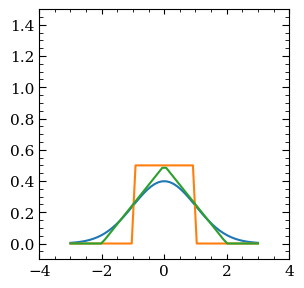

In [35]:
plt.plot(xs, G)
plt.plot(xs, G1)
plt.plot(xs, G2)

plt.xlim(-4,4)
plt.ylim(-0.1, 1.5)

In [8]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from galaxy_generator import simuale_perfect_galaxy, add_source_to_image, sky_noise

In [9]:
perfect_img, params, rpet = simuale_perfect_galaxy(15, 5, 0.3, 21, 1, 1, 0, 10)

passband_sdss_r


GalSimIncompatibleValuesError: red_limit and blue_limit are required if throughput is not a LookupTable. Values {'blue_limit': None, 'red_limit': None, 'throughput': 'passband_sdss_r'}